# Week 1 Seminar

A/B experiment analysis

In [22]:
import glob
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

%matplotlib inline

In [23]:
experiment = "AB"

In [24]:
data = pd.concat([
    pd.read_json(data_path, lines=True)
    for data_path
    in glob.glob("/tmp/AB/data.json")
])

data

,message,timestamp,user,track,time,latency,recommendation,experiments
0,next,2024-04-17 16:26:10.363,5211,6754,1.00,1.644e-03,1111.0,{'AB': 'C'}
1,next,2024-04-17 16:26:10.366,3745,15007,1.00,8.659e-04,3775.0,{'AB': 'C'}
2,next,2024-04-17 16:26:10.369,8818,3484,1.00,7.231e-04,12274.0,{'AB': 'T1'}
3,next,2024-04-17 16:26:10.372,922,1117,1.00,7.088e-04,314.0,{'AB': 'C'}
4,next,2024-04-17 16:26:10.374,5211,1111,0.09,7.877e-04,542.0,{'AB': 'C'}
...,...,...,...,...,...,...,...,...
41194,next,2024-04-17 16:27:58.515,7195,8405,0.17,6.132e-04,1103.0,{'AB': 'C'}
41195,next,2024-04-17 16:27:58.521,7195,1103,0.04,5.913e-04,4450.0,{'AB': 'C'}
41196,next,2024-04-17 16:27:58.526,7195,4450,0.05,6.671e-04,482.0,{'AB': 'C'}
41197,next,2024-04-17 16:27:58.531,7195,482,0.42,5.805e-04,4081.0,{'AB': 'C'}


In [25]:
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

In [26]:
data.groupby("treatment").count()

,message,timestamp,user,track,time,latency,recommendation,experiments
treatment,,,,,,,,
C,19288,19288,19288,19288,19288,19288,17238,19288
T1,21911,21911,21911,21911,21911,21911,19961,21911


## Visualize sessions

In [27]:
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)
        
        session = session._replace(
            tracks = session.tracks + 1, 
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,
        )
        
        if row["message"] == "last":
            sessions.append(session._asdict())
            session = None
    return sessions

In [28]:
sessions = (
    data
    .groupby(["user", "treatment"])
    .apply(sessionize)
    .explode()
    .apply(pd.Series)
)

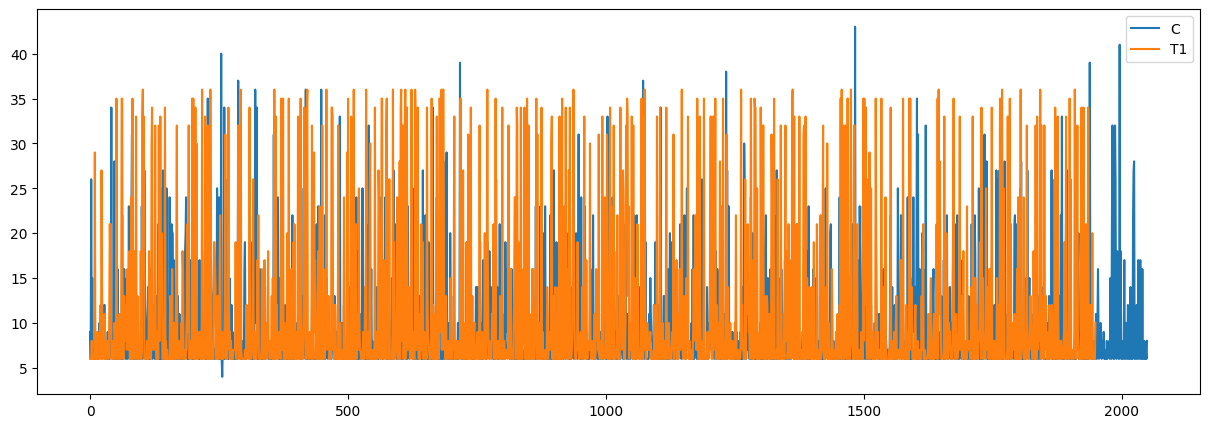

In [29]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["tracks"], label=treatment)
ax.legend()
pass

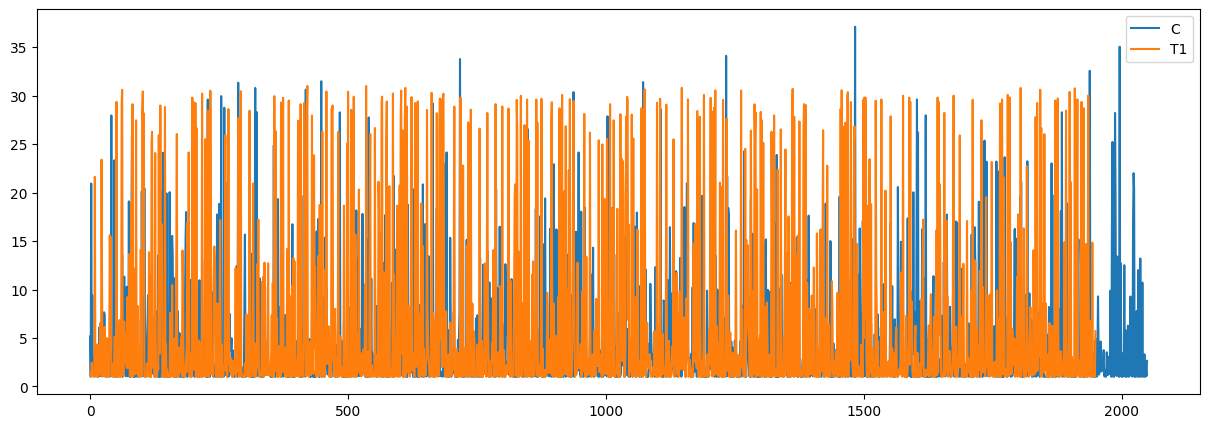

In [30]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["time"], label=treatment)
ax.legend()
pass

## Analyze the experiment

In [31]:
user_level_data = (
  sessions
    .reset_index()
    .groupby(["user", "treatment"])
    .agg(
        {
            "timestamp": "count",
            "tracks": "sum",
            "time": "sum",
            "latency": "sum"
        }
    )
)

user_level_data["sessions"] = user_level_data["timestamp"]
user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

metrics = [
    "time", 
    "sessions", 
    "mean_request_latency", 
    "mean_tracks_per_session", 
    "mean_time_per_session"
]

user_level_metrics = user_level_data[metrics].copy().reset_index()

In [32]:
treatment_level_metrics = (
    user_level_metrics
    .groupby("treatment")[metrics]
    .agg(["count", "mean", "var"])
)

In [33]:
def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)


effects = []

control = [data for treatment, data in treatment_level_metrics.iterrows() if treatment == "C"][0]

for treatment, row in treatment_level_metrics.iterrows():
    if treatment == "C":
        continue
    
    for metric in metrics:
        control_mean = control[metric]["mean"]
        treatment_mean = row[metric]["mean"]
        
        effect = treatment_mean - control_mean
        conf_int = ci(
            control[metric]["count"],
            row[metric]["count"],
            control[metric]["var"],
            row[metric]["var"],
        )
        effects.append({
            "treatment": treatment,
            "metric": metric,
            "control_mean": control_mean,
            "treatment_mean": treatment_mean,
            "effect": effect / control_mean * 100,
            "lower": (effect - conf_int) / control_mean * 100,
            "upper": (effect + conf_int) / control_mean * 100,
            "significant": (effect + conf_int) * (effect - conf_int) > 0
        })

In [34]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,39.066,50.615,27.517,5.438,7.562,True
1,T1,sessions,-1.739,0.974,-4.452,1.236,1.214,False
3,T1,mean_tracks_per_session,19.373,24.591,14.155,9.382,11.199,True
4,T1,mean_time_per_session,41.459,52.504,30.415,4.371,6.184,True
2,T1,mean_request_latency,-14.348,-12.486,-16.210,0.755,0.647,True
